# Use Vortex and Epygram to compute a mean 850hPa temperature error

In [1]:
%load_ext ivortex
%vortex tmpcocoon
%matplotlib inline
import bronx
import common.util.usepygram
import numpy as np

# [2018/08/09-17:32:15][vortex.sessions][_set_rundir:0150][WARNING]: Session <root> is changing its working directory </sauvegarde/vortex-dev/vortex/examples/notebooks/integration>
# [2018/08/09-17:32:15][vortex.sessions][_set_rundir:0153][INFO]: Session <root> set rundir </home/meunierlf/vortex-workdir/auto_cocoon_6pMQpb>
# [2018/08/09-17:32:16][common.util.usepygram][<module>:0027][INFO]: Epygram 1.3.2 loaded.


Vortex 1.4.0 loaded ( Thursday 09. August 2018, at 17:32:15 )
The working directory is now: /home/meunierlf/vortex-workdir/auto_cocoon_6pMQpb/root


## Retrieve forecast files

In [2]:
period_begin = bronx.stdtypes.date.Date('2018070100')
period_end = bronx.stdtypes.date.Date('2018073100')
period_step = bronx.stdtypes.date.Period('P1D')

target_term = bronx.stdtypes.date.Time('PT72H')
target_domain = 'glob05'
target_suite = 'oper'

In [3]:
dates = list(bronx.stdtypes.date.daterange(period_begin, period_end, period_step))

rhs_fc = toolbox.input(now=True, verbose=False, loglevel='warning',
                       # Resource
                       kind='gridpoint', nativefmt='grib', model='arpege', origin='hst',
                       date=dates, term=target_term, cutoff='production', geometry=target_domain,
                       # Provider
                       vapp='arpege', vconf='4dvarfr', suite=target_suite, namespace='[suite].multi.fr',
                       # Container
                       local='FC_[geometry:area]_[date:ymdh]_[term:fmth].grib', format='[nativefmt]',
                      )

## Retrieve reference analysis

In [4]:
fc_an_pairs = []
for rh in rhs_fc:
    an_ref = toolbox.input(now=True, verbose=False, loglevel='warning',
                           # Resource
                           kind='gridpoint', nativefmt='grib', model='arpege', origin='hst',
                           date=rh.resource.date + rh.resource.term, term=0, cutoff='production',
                           geometry=target_domain,
                           # Provider
                           vapp='arpege', vconf='4dvarfr', suite=target_suite, namespace='[suite].multi.fr',
                           # Container
                           local='AN_[geometry:area]_[date:ymdh]_[term:fmth].grib', format='[nativefmt]',
                          )
    fc_an_pairs.append((rh, an_ref[0]))

In [5]:
%ls

AN_GLOB05_2018070400_0000.grib  FC_GLOB05_2018070100_0072.grib
AN_GLOB05_2018070500_0000.grib  FC_GLOB05_2018070200_0072.grib
AN_GLOB05_2018070600_0000.grib  FC_GLOB05_2018070300_0072.grib
AN_GLOB05_2018070700_0000.grib  FC_GLOB05_2018070400_0072.grib
AN_GLOB05_2018070800_0000.grib  FC_GLOB05_2018070500_0072.grib
AN_GLOB05_2018070900_0000.grib  FC_GLOB05_2018070600_0072.grib
AN_GLOB05_2018071000_0000.grib  FC_GLOB05_2018070700_0072.grib
AN_GLOB05_2018071100_0000.grib  FC_GLOB05_2018070800_0072.grib
AN_GLOB05_2018071200_0000.grib  FC_GLOB05_2018070900_0072.grib
AN_GLOB05_2018071300_0000.grib  FC_GLOB05_2018071000_0072.grib
AN_GLOB05_2018071400_0000.grib  FC_GLOB05_2018071100_0072.grib
AN_GLOB05_2018071500_0000.grib  FC_GLOB05_2018071200_0072.grib
AN_GLOB05_2018071600_0000.grib  FC_GLOB05_2018071300_0072.grib
AN_GLOB05_2018071700_0000.grib  FC_GLOB05_2018071400_0072.grib
AN_GLOB05_2018071800_0000.grib  FC_GLOB05_2018071500_0072.grib
AN_GLOB05_2018071900_0000.grib  FC_GLOB05_2018071600_00

## Compute error fields for temperature at 850hPa

### Compute individual differences and store them in a NumPy array

In [6]:
grip = dict(level=850, typeOfLevel='isobaricInhPa', shortName='t')

t850_errors = None
nitems = len(fc_an_pairs)
for i, (fc, an) in enumerate(fc_an_pairs):
    fc850 = fc.contents.data.readfield(grip)
    an850 = an.contents.data.readfield(grip)
    if t850_errors is None:
        # Create an empty 3D array (the last dimension is time)
        t850_errors = np.ma.empty(list(fc850.data.shape) + [nitems, ], dtype=fc850.data.dtype)
    # t850_errors[..., i] = np.ma.abs(fc850.data - an850.data)  # For the absolute error
    t850_errors[..., i] = fc850.data - an850.data

### Compute the mean over the whole period

In [7]:
# Create an epygram field that is a clone of the first t850 field
err_mean = rhs_fc[0].contents.data.readfield(grip).clone()
# Compute the mean error
err_mean.data = np.ma.mean(t850_errors, axis=2)

### Print some stats and draw a plot

In [8]:
err_mean.stats()

{u'max': 3.5795851500953204,
 u'mean': -0.1178708515336146,
 u'min': -5.988682727170345,
 u'nonzero': 259920,
 u'quadmean': 0.8284441736876074,
 u'std': 0.8200159823294196}

(<matplotlib.figure.Figure at 0x7f8cbf2ee750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8cb1020d50>)

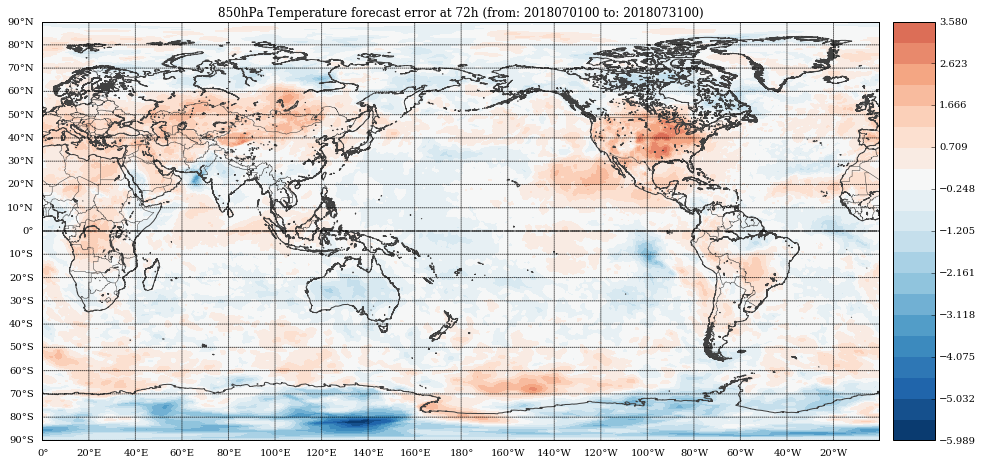

In [9]:
err_mean.plotfield(title=("850hPa Temperature forecast error at {term.hour:d}h (from: {begin.ymdh:s} to: {end.ymdh:s})".
                          format(term=target_term, begin=period_begin, end=period_end)),
                   colormap="RdBu_r", center_cmap_on_0=True)